# BiLSTM-CRF Named Entity Recognition (NER) on GMB Dataset

This notebook implements a **deep learning-based Named Entity Recognition (NER)** system using a **BiLSTM-CRF** architecture on the Groningen Meaning Bank (GMB) dataset.

It follows the steps:
1. **Loading & preprocessing** the GMB data (tab-separated: `Sentence #`, `Word`, `POS`, `Tag`).
2. **Building vocabularies** for words and tags (with `<OOV>`, `<UNK>`, `<PAD>`, `<START>`, `<STOP>`).
3. **Encoding & padding** sentences and tag sequences.
4. Implementing a **BiLSTM-CRF** model in PyTorch.
5. **Training** the model.
6. **Evaluating** with accuracy, classification report, and confusion matrix.


In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [2]:
# === Imports & configuration ===
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure we're using CPU (you can switch to CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cpu


## (a) Loading and Preprocessing the GMB Data

In [3]:
# === Load the GMB dataset ===

def load_data(file_path):
    """Load GMB tab-separated data and group tokens by sentence.

    Expected columns: Sentence #, Word, POS, Tag
    """
    # Read the tab-separated GMB data
    data = pd.read_csv(
        file_path,
        delimiter='\t',
        header=0,            # the uploaded file has a header row
        names=["Sentence #", "Word", "POS", "Tag"],
        encoding='ISO-8859-1'
    )

    # Some files use float sentence IDs, ensure integers
    data["Sentence #"] = data["Sentence #"].astype(str)
    # Group by sentence and collect words and tags
    sentences, ner_tags = [], []
    for _, grp in data.groupby("Sentence #"):
        sentences.append(grp["Word"].tolist())
        ner_tags.append(grp["Tag"].tolist())
    return sentences, ner_tags

# Path to the dataset (adjust if needed)
gmb_path = "GMB_dataset.txt"  # if running here in ChatGPT, this file should be in the same directory

if not os.path.exists(gmb_path):
    # Fallback for this environment
    alt_path = "/mnt/data/GMB_dataset.txt"
    if os.path.exists(alt_path):
        gmb_path = alt_path

print("Using dataset path:", gmb_path)

sentences, ner_tags = load_data(gmb_path)
print(f"Total sentences: {len(sentences)}")
print("Example sentence:", sentences[0][:20])
print("Example tags:    ", ner_tags[0][:20])


Using dataset path: GMB_dataset.txt
Total sentences: 2999
Example sentence: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops']
Example tags:     ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O']


### Train/Test Split and Vocabulary Construction

In [4]:
# === Train/Test split (80/20) ===
train_sents, test_sents, train_tags, test_tags = train_test_split(
    sentences, ner_tags, test_size=0.2, random_state=42
)
print(f"Training sentences: {len(train_sents)}, Testing sentences: {len(test_sents)}")


# === Build vocabularies ===
word_vocab = {"<PAD>": 0, "<OOV>": 1}
for sent in train_sents:
    for w in sent:
        if w not in word_vocab:
            word_vocab[w] = len(word_vocab)

tag_vocab = {"<PAD>": 0, "<UNK>": 1}
for tag_seq in train_tags:
    for t in tag_seq:
        if t not in tag_vocab:
            tag_vocab[t] = len(tag_vocab)

# Special tags for CRF
START_TAG, STOP_TAG = "<START>", "<STOP>"
tag_vocab[START_TAG] = len(tag_vocab)
tag_vocab[STOP_TAG] = len(tag_vocab)

print("Vocab size (words):", len(word_vocab))
print("Vocab size (tags):", len(tag_vocab))
print("Tag vocab:", tag_vocab)


Training sentences: 2399, Testing sentences: 600
Vocab size (words): 7812
Vocab size (tags): 21
Tag vocab: {'<PAD>': 0, '<UNK>': 1, 'O': 2, 'B-gpe': 3, 'B-geo': 4, 'B-tim': 5, 'B-per': 6, 'B-org': 7, 'I-org': 8, 'I-per': 9, 'I-geo': 10, 'B-art': 11, 'I-tim': 12, 'I-gpe': 13, 'B-eve': 14, 'I-eve': 15, 'B-nat': 16, 'I-nat': 17, 'I-art': 18, '<START>': 19, '<STOP>': 20}


### Encoding Sentences and Padding Sequences

In [5]:
# === Encode & pad sentences and tags ===

def encode_and_pad(sent_list, tag_list, word_vocab, tag_vocab, max_len=None):
    """Encode words and tags as indices and pad to max_len."""
    if max_len is None:
        max_len = max(len(s) for s in sent_list)
    X, Y, lengths = [], [], []
    for words, tags in zip(sent_list, tag_list):
        lengths.append(len(words))
        w_idx = [word_vocab.get(w, word_vocab["<OOV>"]) for w in words]
        t_idx = [tag_vocab.get(t, tag_vocab["<UNK>"]) for t in tags]
        # pad
        pad_len = max_len - len(w_idx)
        if pad_len > 0:
            w_idx += [word_vocab["<PAD>"]] * pad_len
            t_idx += [tag_vocab["<PAD>"]] * pad_len
        X.append(w_idx)
        Y.append(t_idx)
    return np.array(X), np.array(Y), lengths, max_len

# Determine max sequence length across train and test
max_len = max(max(len(s) for s in train_sents), max(len(s) for s in test_sents))
print("Max sentence length:", max_len)

train_X, train_Y, train_lens, max_len = encode_and_pad(
    train_sents, train_tags, word_vocab, tag_vocab, max_len=max_len
)
test_X, test_Y, test_lens, _ = encode_and_pad(
    test_sents, test_tags, word_vocab, tag_vocab, max_len=max_len
)

print("Train X shape:", train_X.shape, "Train Y shape:", train_Y.shape)


Max sentence length: 70
Train X shape: (2399, 70) Train Y shape: (2399, 70)


## (b) BiLSTM-CRF Model Definition

In [6]:
# === BiLSTM-CRF model ===

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_idx, embedding_dim=100, hidden_dim=128):
        super(BiLSTM_CRF, self).__init__()
        self.tag_to_idx = tag_to_idx
        self.tagset_size = len(tag_to_idx)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Embedding layer for words
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        # BiLSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        # Linear layer for emissions
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # CRF transitions: transitions[i, j] = score of j -> i
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # Indices for special tags
        self.START_IDX = tag_to_idx["<START>"]
        self.STOP_IDX = tag_to_idx["<STOP>"]
        self.PAD_IDX = tag_to_idx["<PAD>"]

        # Disallow transitions into START, out of STOP, into/out of PAD
        self.transitions.data[self.START_IDX, :] = -10000.0
        self.transitions.data[:, self.STOP_IDX] = -10000.0
        self.transitions.data[self.PAD_IDX, :] = -10000.0
        self.transitions.data[:, self.PAD_IDX] = -10000.0

        # Dropout
        self.dropout = nn.Dropout(0.1)

    def _get_lstm_features(self, sentence):
        # sentence: (seq_len,) indices
        embeds = self.word_embeds(sentence).unsqueeze(1)  # (seq_len, 1, emb_dim)
        lstm_out, _ = self.lstm(embeds)                   # (seq_len, 1, hidden_dim)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)  # (seq_len, hidden_dim)
        feats = self.hidden2tag(lstm_out)                           # (seq_len, tagset_size)
        return feats

    def _forward_alg(self, feats):
        # Forward algorithm in log-space
        init_alphas = torch.full((1, self.tagset_size), -10000.0, device=feats.device)
        init_alphas[0, self.START_IDX] = 0.

        forward_var = init_alphas
        for feat in feats:
            alphas_t = []
            for next_tag in range(self.tagset_size):
                emit_score = feat[next_tag].view(1, -1)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(torch.logsumexp(next_tag_var, dim=1).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.STOP_IDX]
        alpha = torch.logsumexp(terminal_var, dim=1)
        return alpha

    def _score_sentence(self, feats, tags):
        # Calculate the score for a given tag sequence
        score = torch.zeros(1, device=feats.device)
        tags = torch.cat([torch.tensor([self.START_IDX], dtype=torch.long, device=feats.device), tags])
        for i, feat in enumerate(feats):
            score += self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score += self.transitions[self.STOP_IDX, tags[-1]]
        return score

    # def _viterbi_decode(self, feats):
    #     backpointers = []

    #     init_vvars = torch.full((1, self.tagset_size), -10000.0, device=feats.device)
    #     init_vvars[0, self.START_IDX] = 0.

    #     forward_var = init_vvars
    #     for feat in feats:
    #         bptrs_t = []
    #         viterbivars_t = []
    #         for next_tag in range(self.tagset_size):
    #             next_tag_var = forward_var + self.transitions[next_tag]
    #             best_tag_id = torch.argmax(next_tag_var, dim=1).item()
    #             bptrs_t.append(best_tag_id)
    #             viterbivars_t.append(next_tag_var[0, best_tag_id] + feat[next_tag])
    #         forward_var = torch.cat(viterbivars_t).view(1, -1)
    #         backpointers.append(bptrs_t)

    #     terminal_var = forward_var + self.transitions[self.STOP_IDX]
    #     best_tag_id = torch.argmax(terminal_var, dim=1).item()

    #     # Follow backpointers
    #     best_path = [best_tag_id]
    #     for bptrs_t in reversed(backpointers):
    #         best_tag_id = bptrs_t[best_tag_id]
    #         best_path.append(best_tag_id)
    #     best_path.pop()  # remove START
    #     best_path.reverse()
    #     return best_path

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize Viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.0, device=feats.device)
        init_vvars[0, self.START_IDX] = 0.0

        forward_var = init_vvars  # shape: (1, tagset_size)

        for feat in feats:
            bptrs_t = []        # backpointers for this time step
            viterbivars_t = []  # best scores for each tag at this time step

            for next_tag in range(self.tagset_size):
                # Score of previous tags -> next_tag
                next_tag_var = forward_var + self.transitions[next_tag]
                best_prev_tag = torch.argmax(next_tag_var, dim=1).item()
                bptrs_t.append(best_prev_tag)

                # Best score for next_tag (scalar tensor)
                best_score = next_tag_var[0, best_prev_tag] + feat[next_tag]
                viterbivars_t.append(best_score)

            # Stack scalars into (tagset_size,) then unsqueeze to (1, tagset_size)
            forward_var = torch.stack(viterbivars_t).unsqueeze(0)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.STOP_IDX]
        best_last_tag = torch.argmax(terminal_var, dim=1).item()

        # Backtrack to get best path
        best_path = [best_last_tag]
        for bptrs_t in reversed(backpointers):
            best_last_tag = bptrs_t[best_last_tag]
            best_path.append(best_last_tag)

        best_path.pop()   # remove START
        best_path.reverse()
        return best_path
    
    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):
        feats = self._get_lstm_features(sentence)
        tag_seq = self._viterbi_decode(feats)
        return tag_seq


# Instantiate the model
vocab_size = len(word_vocab)
# model = BiLSTM_CRF(vocab_size, tag_vocab, embedding_dim=100, hidden_dim=128).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model = BiLSTM_CRF(len(word_vocab), tag_vocab, embedding_dim=100, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


print(model)


BiLSTM_CRF(
  (word_embeds): Embedding(7812, 100)
  (lstm): LSTM(100, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=21, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


## (c) Training the BiLSTM-CRF Model

In [7]:
# === Training ===

N_EPOCHS = 7  # increase to 5+ for better accuracy in a real run

def train_epoch(model, optimizer, train_X, train_Y, train_lens):
    model.train()
    total_loss = 0.0
    for i in range(len(train_X)):
        length = train_lens[i]
        sentence_idx = torch.tensor(train_X[i][:length], dtype=torch.long, device=device)
        tags_idx = torch.tensor(train_Y[i][:length], dtype=torch.long, device=device)
        optimizer.zero_grad()
        loss = model.neg_log_likelihood(sentence_idx, tags_idx)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 500 == 0:
            print(f"  step {i}, loss = {loss.item():.4f}")
    return total_loss / len(train_X)

for epoch in range(1, N_EPOCHS + 1):
    avg_loss = train_epoch(model, optimizer, train_X, train_Y, train_lens)
    print(f"Epoch {epoch}/{N_EPOCHS} - avg loss: {avg_loss:.4f}")


  step 0, loss = 137.9991
  step 500, loss = 6.3842
  step 1000, loss = 8.6615
  step 1500, loss = 1.0010
  step 2000, loss = 2.4134
Epoch 1/7 - avg loss: 6.9583
  step 0, loss = 3.2871
  step 500, loss = 1.2703
  step 1000, loss = 7.0743
  step 1500, loss = 0.1844
  step 2000, loss = 0.4108
Epoch 2/7 - avg loss: 2.4627
  step 0, loss = 3.2990
  step 500, loss = 0.4392
  step 1000, loss = 8.1070
  step 1500, loss = 0.0443
  step 2000, loss = 0.3567
Epoch 3/7 - avg loss: 1.4369
  step 0, loss = 2.3182
  step 500, loss = 0.8967
  step 1000, loss = 2.0954
  step 1500, loss = 0.1183
  step 2000, loss = 0.0876
Epoch 4/7 - avg loss: 1.0683
  step 0, loss = 0.8417
  step 500, loss = 0.1387
  step 1000, loss = 3.2639
  step 1500, loss = 0.3408
  step 2000, loss = 0.2339
Epoch 5/7 - avg loss: 0.7747
  step 0, loss = 2.8420
  step 500, loss = 0.4528
  step 1000, loss = 2.7653
  step 1500, loss = 0.0018
  step 2000, loss = 0.0071
Epoch 6/7 - avg loss: 0.6697
  step 0, loss = 4.0839
  step 500, lo

## Evaluation on Test Set

Test accuracy: 0.9112135408795526

Classification report:

              precision    recall  f1-score   support

           O     0.9848    0.9512    0.9677     11231
       B-geo     0.6891    0.6806    0.6848       407
       I-geo     0.4588    0.6000    0.5200        65
       B-org     0.4699    0.5799    0.5191       269
       I-org     0.5362    0.6343    0.5812       175
       B-per     0.6367    0.7056    0.6694       231
       I-per     0.6846    0.8127    0.7432       251
       B-gpe     0.6493    0.7602    0.7004       246
       I-gpe     0.3000    0.5000    0.3750         6
       B-tim     0.5013    0.8000    0.6164       235
       I-tim     0.4059    0.5325    0.4607        77
       B-art     0.0000    0.0000    0.0000         9
       I-art     0.0000    0.0000    0.0000         3
       B-eve     0.3333    0.2308    0.2727        13
       I-eve     0.1667    0.1538    0.1600        13
       B-nat     0.5000    0.5000    0.5000         2
       I-nat     1.000

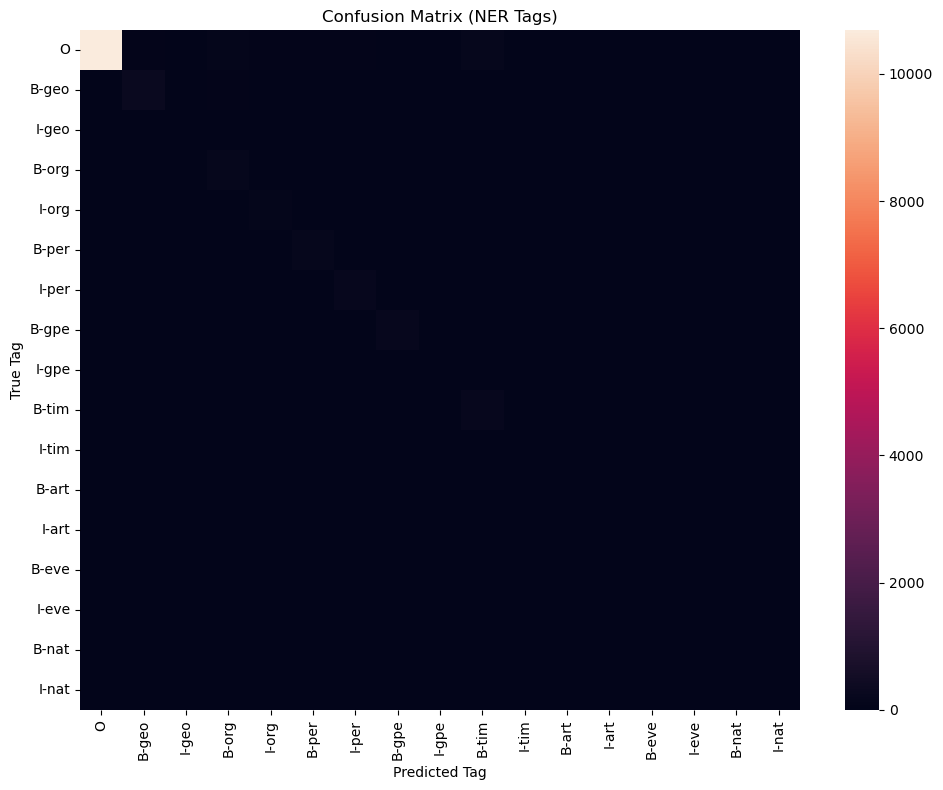

In [8]:
# === Evaluation ===

model.eval()
inv_tag_vocab = {v: k for k, v in tag_vocab.items()}

y_true, y_pred = [], []

with torch.no_grad():
    for i in range(len(test_X)):
        length = test_lens[i]
        sentence_idx = torch.tensor(test_X[i][:length], dtype=torch.long, device=device)
        pred_idx_seq = model(sentence_idx)
        pred_tags = [inv_tag_vocab[idx] for idx in pred_idx_seq]

        true_tags = test_tags[i]  # list of strings
        # Ensure same length (they should match)
        min_len = min(len(true_tags), len(pred_tags))
        y_true.extend(true_tags[:min_len])
        y_pred.extend(pred_tags[:min_len])

# Define the label order (excluding special tokens)
labels = [
    "O",
    "B-geo","I-geo","B-org","I-org","B-per","I-per",
    "B-gpe","I-gpe","B-tim","I-tim","B-art","I-art",
    "B-eve","I-eve","B-nat","I-nat"
]
labels = [l for l in labels if l in tag_vocab]  # filter to those present

print("Test accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, labels=labels, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (NER Tags)")
plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.tight_layout()
plt.show()
